In [1]:
%matplotlib inline

import re
import nltk
import time
import torch
import random
import sklearn
import itertools
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from scipy.interpolate import make_interp_spline

# Gender classification assignment

You are to follow the instructions below and fill each cell as instructed.
Once ready, submit this notebook on VLE with all the outputs included (run all your code and don't clear any output cells).
Do not submit anything else apart from the notebook and do not use any extra data apart from what is provided.

You will be working on classifying the genders of people from their blog posts using a data set called the [Blog Authorship Corpus](https://www.kaggle.com/rtatman/blog-authorship-corpus).
This has been pre-split and reduced for you to use in this assignment.

10% of the marks from this assignment are based on neatness.

This assignment will carry 40% of the final mark.

## Data processing (10%)

You have a train/dev/test split data set consisting of CSV files with two fields: gender and text.
The gender field contains either 'male' or 'female' whilst the text is a string containing text from blog posts.

Do the following tasks:

Load these three CSV files and tokenise each text.

In [2]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")
dev_set = pd.read_csv("dev.csv")

train_set_x = train_set['text']
train_set_y = train_set['gender']

test_set_x = test_set['text']
test_set_y = test_set['gender']

dev_set_x = dev_set['text']
dev_set_y = dev_set['gender']

def preprocess(x):
    return x.lower()

train_set_x = train_set_x.apply(preprocess)
train_set_x = train_set_x.apply(preprocess)
dev_set_x = dev_set_x.apply(preprocess)

train_token_x = train_set_x.apply(nltk.tokenize.word_tokenize)
test_token_x = test_set_x.apply(nltk.tokenize.word_tokenize)
dev_token_x = dev_set_x.apply(nltk.tokenize.word_tokenize)

Write code that counts the number of lines in each data set as well as the maximum number of tokens in each data set.

In [3]:
train_len = len(train_set.index)
test_len = len(test_set.index)
dev_len = len(dev_set.index)

print("Train Set no. of lines:", str(train_len))
print("Test Set no. of lines:", str(test_len))
print("Dev Set no. of lines:", str(dev_len))
print()

train_lens = [len(x) for x in train_token_x]
train_max = max(train_lens)
test_lens = [len(x) for x in test_token_x]
test_max = max(test_lens)
dev_lens = [len(x) for x in dev_token_x]
dev_max = max(dev_lens)

print("Train Set max tokens:", str(train_max))
print("Test Set max tokens:", str(test_max))
print("Dev Set max tokens:", str(dev_max))

Train Set no. of lines: 37208
Test Set no. of lines: 4652
Dev Set no. of lines: 4650

Train Set max tokens: 97
Test Set max tokens: 66
Dev Set max tokens: 61


Convert each data set's labels (gender) into numeric form.

In [4]:
categories = sorted(set(train_set_y))

cat2index = {cat: i for (i, cat) in enumerate(categories)}

tensor_indexed_train_y = torch.tensor([cat2index[category] for category in train_set_y], dtype=torch.int64)
tensor_indexed_test_y = torch.tensor([cat2index[category] for category in test_set_y], dtype=torch.int64)
tensor_indexed_dev_y = torch.tensor([cat2index[category] for category in dev_set_y], dtype=torch.int64)

Extract a vocabulary consisting of the tokens that occur at least 5 times in the train set and output the size of your vocabulary.
Include the unknown token and pad token in the vocabulary.

In [5]:
min_freq = 5

frequencies = collections.Counter(word for text in train_token_x for word in text)
vocab = sorted(frequencies.keys(), key=frequencies.get, reverse=True)
while frequencies[vocab[-1]] < min_freq:
    vocab.pop()
vocab = ['<PAD>', '<UNK>'] + sorted(vocab)

print("Length of vocabulary:", len(vocab))

Length of vocabulary: 7112


Create binary bag of words feature vectors for all data set texts using the vocabulary created above (include stop words).

In [6]:
encoder = sklearn.feature_extraction.text.CountVectorizer(vocabulary=vocab, binary=True, analyzer=lambda text: text, dtype=np.float32)
encoder.fit(train_set_x)

train_x_vecs = encoder.transform(train_token_x).toarray()
test_x_vecs = encoder.transform(test_token_x).toarray()
dev_x_vecs = encoder.transform(dev_token_x).toarray()

Create a data set of indexified token sequences for all texts using the vocabulary created above, making use of unknown tokens and pad tokens.

In [7]:
word2index = {word: i for (i, word) in enumerate(vocab)}

for i in range(len(train_token_x)):
    for j in range(len(train_token_x[i])):
        if train_token_x[i][j] not in word2index:
            train_token_x[i][j] = '<UNK>'
    train_token_x[i].extend(['<PAD>']*(train_max - len(train_token_x[i])))
    
for i in range(len(test_token_x)):
    for j in range(len(test_token_x[i])):
        if test_token_x[i][j] not in word2index:
            test_token_x[i][j] = '<UNK>'
    test_token_x[i].extend(['<PAD>']*(test_max - len(test_token_x[i])))
    
for i in range(len(dev_token_x)):
    for j in range(len(dev_token_x[i])):
        if dev_token_x[i][j] not in word2index:
            dev_token_x[i][j] = '<UNK>'
    dev_token_x[i].extend(['<PAD>']*(dev_max - len(dev_token_x[i])))

indexed_train_x = torch.tensor([[word2index[word] for word in text] for text in train_token_x], dtype=torch.int64)
tensor_train_lens = torch.tensor(train_lens, dtype=torch.int64)
indexed_test_x = torch.tensor([[word2index[word] for word in text] for text in test_token_x], dtype=torch.int64)
tensor_test_lens = torch.tensor(test_lens, dtype=torch.int64)
indexed_dev_x = torch.tensor([[word2index[word] for word in text] for text in dev_token_x], dtype=torch.int64)
tensor_dev_lens = torch.tensor(dev_lens, dtype=torch.int64)

Write code that counts the percentage of tokens in each data set that are unknown tokens (not including pad tokens).

In [8]:
def unk_percent(tokens):
    total_tokens = sum([len(x) for x in tokens])    
    unk_tokens = sum([1 if word == "<UNK>" else 0 for text in tokens for word in text])
    return (unk_tokens/total_tokens)

train_unkper = unk_percent(train_token_x)
test_unkper = unk_percent(test_token_x)
dev_unkper = unk_percent(dev_token_x)

print("Train Set Unknown %: {:.2%}".format(train_unkper))
print("Test Set Unknown %: {:.2%}".format(test_unkper))
print("Dev Set Unknown %: {:.2%}".format(dev_unkper))

Train Set Unknown %: 1.31%
Test Set Unknown %: 6.85%
Dev Set Unknown %: 2.32%


## Linear regression classification (20%)

Write a linear regression classifier (single layer neural net) that is trained to classify the author gender from the bag of words vector of the text.
You do not need to perform any hyperparameter tuning.
Use L1 weight decay regularisation.

In [9]:
class Linear_Model(torch.nn.Module):
    
    def __init__(self, vocab_size, num_categories):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros((vocab_size, num_categories), dtype=torch.float32, requires_grad=True))
        self.b = torch.nn.Parameter(torch.zeros((num_categories,), dtype=torch.float32, requires_grad=True))

    def forward(self, x):
        return x@self.w + self.b

In [10]:
lin_model = Linear_Model(len(vocab), 2)
lin_model.to('cpu')

optimiser = torch.optim.Adam(lin_model.parameters())

tensor_train_x_vecs = torch.tensor(train_x_vecs, dtype=torch.float32)
# tensor_train_y = torch.tensor(train_y_indexes, dtype=torch.int64)

print('step', 'error')
for step in range(1, 200+1):
    optimiser.zero_grad()
    output = lin_model(tensor_train_x_vecs)
    error = torch.nn.functional.cross_entropy(output, tensor_indexed_train_y) + lin_model.w.abs().mean()
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())

step error
100 0.6532608270645142
200 0.6431172490119934


Measure the accuracy, precision, recall, and F1-score of this classifier on the test set.

In [11]:
def calc_accuracy(TP, TN, tot):
    return (TP + TN)/tot

def calc_precision(TP, FP):
    return TP/(TP + FP)

def calc_recall(TP, FN):
    return TP/(TP + FN)

def calc_f1_score(precision, recall):
    num = precision * recall
    denom = precision + recall
    return 2 * (num/denom)

In [12]:
tensor_test_x_vecs = torch.tensor(test_x_vecs, dtype=torch.float32)

targets = np.array(tensor_indexed_test_y, np.int64)

with torch.no_grad():
    output_probs = torch.sigmoid(lin_model(tensor_test_x_vecs))
    outputs = output_probs.detach().numpy().argmax(axis=1)

tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(targets)):
    if(targets[i] == outputs[i]):
        if(targets[i] == 0):
            tn += 1
        else:
            tp += 1
    else:
        if(targets[i] == 0):
            fp += 1
        else:
            fn += 1
            
accuracy = calc_accuracy(tp, tn, len(targets))
precision = calc_precision(tp, fp)
recall = calc_recall(tp, fn)
f1_score = calc_f1_score(precision, recall)


print('Accuracy: {:.2%}'.format(accuracy))
print('Precision: {:.2%}'.format(precision))
print('Recall: {:.2%}'.format(recall))
print('F1-Score: {:.2%}'.format(f1_score))


Accuracy: 60.64%
Precision: 60.27%
Recall: 62.42%
F1-Score: 61.33%


Write code that shows the top 10 tokens that are the most important for determining the author gender according to the classifier.

In [13]:
w = np.abs(lin_model.w.detach().numpy())

category_index = 5
weighted_words = sorted(zip(w[:, :].tolist(), vocab), reverse=True)
top_ten = []

print('Top 10 words')
for i, weighted_word in enumerate(weighted_words[:10]):
    m = (weighted_word[0][0] + weighted_word[0][1]) / 2
    mean = "{:.2%}".format(m)
    print(i+1,") ",weighted_word[1]," (",mean,")",sep="")
    top_ten.append(weighted_word[1])

Top 10 words
1) -arv (19.25%)
2) hakx (18.94%)
3) gio (18.93%)
4) jhayne (18.82%)
5) dan (18.73%)
6) venerable (18.60%)
7) 1. (18.58%)
8) killy (18.37%)
9) managed (18.36%)
10) -sane (18.35%)


Write code that, for each data split and gender, shows the percentage of rows that include at least one of these important words (so 6 percentages in all).

In [14]:
def percentageofword(word, dataset, gender):
    count = 0
    total = len(dataset.index)
    for i,text in enumerate(dataset["text"]):
        text = text.lower()
        if(dataset["gender"][i] == gender):
            if(text.find(word) != -1):
                count += 1
    return count/total

top_word = random.randint(0,len(top_ten)-1)

train_percent_male = percentageofword(top_ten[top_word], train_set, "male")
train_percent_female = percentageofword(top_ten[top_word], train_set, "female")

test_percent_male = percentageofword(top_ten[top_word], test_set, "male")
test_percent_female = percentageofword(top_ten[top_word], test_set, "female")

dev_percent_male = percentageofword(top_ten[top_word], dev_set, "male")
dev_percent_female = percentageofword(top_ten[top_word], dev_set, "female")

print("Word:", top_ten[top_word], sep="\t")
print()

print("Train Set Male: {:.2%}".format(train_percent_male))
print("Train Set Female: {:.2%}".format(train_percent_female))
print("Test Set Male: {:.2%}".format(test_percent_male))
print("Test Set Female: {:.2%}".format(test_percent_female))
print("Dev Set Male: {:.2%}".format(dev_percent_male))
print("Dev Set Female: {:.2%}".format(dev_percent_female))

Word:	-sane

Train Set Male: 0.05%
Train Set Female: 0.00%
Test Set Male: 0.06%
Test Set Female: 0.00%
Dev Set Male: 0.06%
Dev Set Female: 0.00%


## Deep learning classifier (50%)

Perform hyperparameter tuning on a deep learning classifier (with a convolutional neural network or a recurrent neural network) that is trained to classify the author gender from the indexified sequences of the text.
Using the dev set for evaluation.
Output the best hyperparameters found and do not store the best trained model as you will be training it again in the next bit.

In [ ]:
class Conv_Model(torch.nn.Module):
    
    def __init__(self, vocab_size, categ_size, embedding_size, window_size, hidden_size, init_dev):
        super().__init__()
        self.window_size = window_size
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (vocab_size, embedding_size)), dtype=torch.float32))
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size, embedding_size, window_size)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((hidden_size,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size, categ_size)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((categ_size,), dtype=torch.float32))

    def forward(self, x, text_lens):
        embedded = self.embedding_matrix[x]
        embedded_t = embedded.transpose(1, 2)
        hidden_t = torch.nn.functional.leaky_relu(torch.nn.functional.conv1d(embedded_t, self.w1, self.b1))
        hidden = hidden_t.transpose(1, 2)

        pad_mask = torch.zeros(hidden.shape, dtype=torch.bool)
        for i in range(hidden.shape[0]):
            for j in range(hidden.shape[1]):
                pad_mask[i, j, :] = j >= (text_lens[i] - self.window_size + 1)
        masked = torch.masked_fill(hidden, pad_mask, torch.tensor(np.inf))
        
        pooled = torch.min(masked, dim=1)[0]
        output = pooled@self.w2 + self.b2
        return output


In [15]:
class Rec_Model(torch.nn.Module):
    
    def __init__(self, vocab_size, categ_size, is_lstm, embedding_size, hidden_size, init_dev):
        super().__init__()
        self.hidden_size = hidden_size
        self.is_lstm = is_lstm
        
        self.embedding_matrix = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (vocab_size, embedding_size)), dtype=torch.float32))
        self.s0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size,)), dtype=torch.float32))
        
        if is_lstm:
            self.lstm = torch.nn.LSTMCell(embedding_size, hidden_size)
            self.c0 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size,)), dtype=torch.float32))

        else:
            self.gru = torch.nn.GRUCell(embedding_size, hidden_size)

        self.w = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_dev, (hidden_size, categ_size)), dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.zeros((categ_size,), dtype=torch.float32))

    def forward(self, x, text_lens):
        batch_size = x.shape[0]
        time_steps = x.shape[1]

        embedded = self.embedding_matrix[x]
        state = self.s0.unsqueeze(0).tile((batch_size, 1))
        if self.is_lstm:
            c = self.c0.unsqueeze(0).tile((batch_size, 1))
        for t in range(time_steps):
            mask = (t < text_lens).unsqueeze(1).tile((1, self.hidden_size))
            if self.is_lstm:
                (next_state, c) = self.lstm(embedded[:, t, :], (state, c))
            else:
                next_state = self.gru(embedded[:, t, :], state)
            state = torch.where(mask, next_state, state)
        return state@self.w + self.b


In [ ]:
embedding_size_set = [2, 3]
cell_type_set = [True, False]
hidden_size_set = [1, 2, 4, 8, 16]
init_dev_set = [10.0, 1.0, 0.1, 0.01, 0.001]

already_generated = set()
best_dev_acc = 0.0
best_hyperparams = None

skip = 50

for i in range(1, 20+1):
    while True:
        embedd_size = random.choice(embedding_size_set)
        cell_type = random.choice(cell_type_set)
        hidden_size = random.choice(hidden_size_set)
        init_dev = random.choice(init_dev_set)
        hyperparams = (embedd_size, cell_type, hidden_size, init_dev)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            break
    if i%skip == 0:
        print('Hyperparameter search attempt:', i)
        print('Embedding Size:', embedd_size)
        print('Cell Type:', ("LSTM" if b_cell_type is True else "GRU"))
        print('Hidden Layer Size:', hidden_size)
        print('Initial Standard Deviation:', init_dev)

    hyp_model = Rec_Model(len(vocab), len(categories), embedding_size=embedd_size, is_lstm=cell_type, hidden_size=hidden_size, init_dev=init_dev)
    hyp_model.to('cpu')
    optimiser = torch.optim.Adam(hyp_model.parameters(), lr=1.0)
    for step in range(1, 40+1):
        optimiser.zero_grad()
        output = hyp_model(indexed_train_x, train_lens)
        error = torch.nn.functional.cross_entropy(output, tensor_train_y)
        error.backward()
        optimiser.step()
        
    print()
    with torch.no_grad():
        targets = np.array(tensor_indexed_dev_y, np.int64)
        output_probs = torch.sigmoid(deep_model(indexed_dev_x, dev_lens))
        outputs = output_probs.detach().numpy().argmax(axis=1)
        dev_acc = (targets == outputs).sum()/len(targets)
    
    if i%skip == 0:
        print('Dev set accuracy:', dev_acc)
    if dev_acc > best_dev_acc:
        best_hyperparams = hyperparams
        best_dev_acc = dev_acc
        print('new best!')
    print()

(b_embedd_size, b_cell_type, b_hidden_size, b_init_dev) = best_hyperparams
print('Best found:')
print('Embedding Size:', b_embedd_size)
print('Cell Type:', ("LSTM" if b_cell_type is True else "GRU"))
print('Hidden Layer Size:', b_hidden_size)
print('Init Stddev:', b_init_dev)
print('Dev Set Accuracy:', best_dev_acc)

Use the hyperparameters found in the previous bit to train the classifier, this time outputting a graph showing the dev set accuracy after every epoch.

In [16]:
def acc_plot(x, y, max_epochs):
    # clear_output(wait=True)
    plt.figure(figsize=(8,8))
    
    x = np.array(x)
    y = np.array(y)
    
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    
    plt.plot(X_, Y_, color='blue')
    
    plt.title('Dev Set Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xlim([0,max_epochs])
    
    y = np.delete(y,0)
    min_y = min(y)
    max_y = max(y)
    min_y -= 5
    max_y += 5
    if min_y < 0:
        min_y = 0
    if max_y > 100:
        max_y = 100
    plt.ylim([min_y, max_y])
    
    plt.show()

In [17]:
b_embedd_size = 3
b_cell_type = True
b_hidden_size = 8
b_init_dev = 0.1

50 0.6923137903213501
0.5681720430107526
100 0.6800097823143005
0.5898924731182795


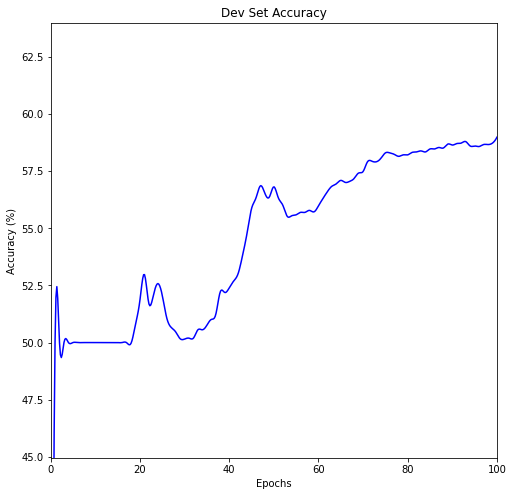

In [18]:
# deep_model = Conv_Model(len(vocab), len(categories), embedding_size=b_embedd_size, window_size=b_wind_size, hidden_size=b_hidden_size, init_dev=b_init_dev)

deep_model = Rec_Model(len(vocab), len(categories), is_lstm=b_cell_type,embedding_size=b_embedd_size, hidden_size=b_hidden_size, init_dev=b_init_dev)

deep_model.to('cpu')

optimiser = torch.optim.Adam(deep_model.parameters())

max_epoch = 100
x = [0]
y = [0]

# print('step', 'error')
for step in range(1, max_epoch+1):
    optimiser.zero_grad()
    output = deep_model(indexed_train_x, tensor_train_lens)
    error = torch.nn.functional.cross_entropy(output, tensor_indexed_train_y)
    error.backward()
    optimiser.step()
    
    with torch.no_grad():
        targets = np.array(tensor_indexed_dev_y, np.int64)
        output_probs = torch.sigmoid(deep_model(indexed_dev_x, tensor_dev_lens))
        outputs = output_probs.detach().numpy().argmax(axis=1)
        dev_acc = (targets == outputs).sum()/len(targets)
    
    x.append(step)
    y.append(dev_acc * 100)

    if step%50 == 0:
        print(step, error.detach().tolist())
        print(dev_acc)
    
acc_plot(x, y, max_epoch)


Measure the accuracy, precision, recall, and F1-score of this classifier on the test set.

In [31]:
targets = np.array(tensor_indexed_test_y, np.int64)

with torch.no_grad():
    output_probs = torch.sigmoid(deep_model(indexed_test_x, tensor_test_lens))
    outputs = output_probs.detach().numpy().argmax(axis=1)

tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(targets)):
    if(targets[i] == outputs[i]):
        if(targets[i] == 0):
            tn += 1
        else:
            tp += 1
    else:
        if(targets[i] == 0):
            fp += 1
        else:
            fn += 1
            
accuracy = calc_accuracy(tp, tn, len(targets))
precision = calc_precision(tp, fp)
recall = calc_recall(tp, fn)
f1_score = calc_f1_score(precision, recall)


print('Accuracy: {:.2%}'.format(accuracy))
print('Precision: {:.2%}'.format(precision))
print('Recall: {:.2%}'.format(recall))
print('F1-Score: {:.2%}'.format(f1_score))

Accuracy: 55.95%
Precision: 53.82%
Recall: 83.79%
F1-Score: 65.55%


Output a confusion matrix of the trained model on the test set.

In [20]:
# function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

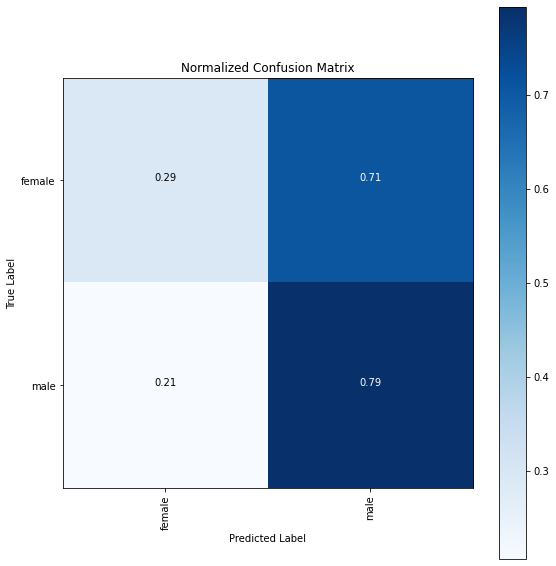

In [21]:
conf_mat = confusion_matrix(targets, outputs)

plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(conf_mat, classes=categories, normalize=True, title='Normalized Confusion Matrix')
# image_name = "Pics/" + dataset + "_" + model_name + "_ConfusionMatrix.png"
# plt.savefig(image_name)
plt.show()

Output 5 examples of correctly classified text for each gender and 5 examples of incorrectly classified text for each gender (so 20 text examples in total), all of which must be from the test set.
This is assuming that you have at least 5 instances of each group.
If you have less, then show whatever is available.

In [35]:
thresh = 5
count = 0
total = 0
correct_male = []
wrong_male = []
correct_female = []
wrong_female = []

while count < thresh * 4:
    total += 1
    if total == len(test_set_x):
        break
    choice = random.randint(0, len(test_set_x) - 1)
    if outputs[choice] == targets[choice]:
        if targets[choice] == 0:
            if len(correct_female) < thresh:
                correct_female.append(choice)
                count += 1
            else:
                continue
        else:
            if len(correct_male) < thresh:
                correct_male.append(choice)
                count += 1
            else:
                continue
    else:
        if targets[choice] == 0:
            if len(wrong_female) < thresh:
                wrong_female.append(choice)
                count += 1
            else:
                continue
        else:
            if len(wrong_male) < thresh:
                wrong_male.append(choice)
                count += 1
            else:
                continue
            
examples = [correct_female, correct_male, wrong_female, wrong_male]

exam_labels = ["Correctly Classified Female Texts", "Correctly Classified Male Texts",
               "Incorrectly Classified Female Texts", "Incorrectly Classified Male Texts"]

for i, example in enumerate(examples):
    print(exam_labels[i] + ":")
    for j, index in enumerate(example):
        print(str(j+1) + ") " + test_set_x[index])
    print()

Correctly Classified Female Texts:
1) urlLink House pictures are up...more words to come!
2) I have my own domain. Yay! www.patchedjeans.com K...I'm going to go back to work now. bye!
3) The Job Hunt I hate looking for a job......hate........Hate.........HATE okay feel better now...
4) Quote of the Day 'He's a rocket scientist?! WOW! I didn't know those really existed!'
5) urlLink My cousin Pasquale with his little cousins

Correctly Classified Male Texts:
1) Me and Caro outside le petit café a la place. Good times urlLink urlLink
2) This is pretty good. urlLink Random Law and Order Plot Generator - BenSinclair.com
3) urlLink The lovely Virginia, looking over our fine city from Central Park.
4) urlLink urlLink audio post powered by urlLink audblog
5) urlLink Asi kedo el gato de un amigo despues de un rato de ocio... urlLink

Incorrectly Classified Female Texts:
1) See how our little guy has grown! http://www.buhbie.com/menu/louie3.htm
2) [Roz] I received this in email a couple days ago

Remember the list of important tokens determined previously (from the logistic regression classifier)?
Write code that takes all the texts in the test set that have at least one of the important tokens and shows the percentage of these texts that were correctly classified.
Similarly, take all the texts that don't have any of the important tokens and show the percentage of these texts that were correctly classified (so 2 percentages in total).

In [23]:
def token_perc(words, dataset, outputs, targets):
    true_imp = 0
    total_imp = 0
    true_other = 0
    total_other = 0
    for i,text in enumerate(dataset["text"]):
        text = text.lower()
        
        if re.compile('|'.join(words),re.IGNORECASE).search(text):
            total_imp += 1
            if outputs[i] == targets[i]:
                true_imp += 1

        else:
            total_other += 1
            if outputs[i] == targets[i]:
                true_other += 1
                
    imp_per = true_imp/total_imp
    other_per = true_other/total_other
            
    return (imp_per, other_per)

In [24]:
imp_tok_per, other_tok_per = token_perc(top_ten, test_set, outputs, targets)


print("%age of Important Tokens: {:.2%}".format(imp_tok_per))
print("%age of Other Tokens: {:.2%}".format(other_tok_per))

%age of Important Tokens: 56.97%
%age of Other Tokens: 54.11%


## Conclusion (10%)

Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about how the different genders write or if it's just basing everything on the words used.